# Learned Decoder
The purpose of this notebook is to investigate whether we can learn the MURA decoder

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision
import torchvision.transforms as transforms
import torch
# from torchsummary import summary
# import sklearn
# import wandb

desktop_path = '/Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)



# # Change plotting parameters
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Times", #"Computer Modern Serif"
#     "figure.figsize" : [15,10],
# })

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
# wandb.login()

Using path =  /Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/
Using cpu device


In [3]:
# Create params dict
params = {
  "image_size": 23,
  "batch_size":100,
}

In [4]:
# Load MNIST and define dataloader
mnist_train = torchvision.datasets.MNIST('../data/MNIST/',download=False)
train_data_loader = torch.utils.data.DataLoader(mnist_train,
                                          batch_size=params['batch_size'],
                                          shuffle=True,
                                          num_workers=8)

In [5]:
# Define transforms
transform_list = [
                transforms.ToTensor(),
                transforms.Resize(params['image_size']),
                transforms.Normalize(0, 1),
                ]

In [163]:
# Load the data and then do MURA transformations
from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.mnist import read_image_file, read_label_file
import MURA as mura

class MNIST_MURA(VisionDataset):
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``MNIST/processed/training.pt``
            and  ``MNIST/processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    urls = [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
    ]
    training_file = 'training.pt'
    test_file = 'test.pt'
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    def __init__(self, root, params, train=True, transform=None, target_transform=None, download=False):
        super(MNIST_MURA, self).__init__(root, transform=transform,
                                    target_transform=target_transform)

        self.train = train  # training set or test set
        self.params = params
        self._read_params(self.params)
        
        if self._check_legacy_exist():
            self.data, self.targets = self._load_legacy_data()
            
        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')
        # Load data
        self.data, self.targets = self._load_data()
    
    
    def _check_exists(self):
        return all(
            check_integrity(os.path.join(self.raw_folder, os.path.splitext(os.path.basename(url))[0]))
            for url, _ in self.resources
        )
    def _check_legacy_exist(self):
        processed_folder_exists = os.path.exists(self.processed_folder)
        if not processed_folder_exists:
            return False
    def _load_legacy_data(self):
        # This is for BC only. We no longer cache the data in a custom binary, but simply read from the raw data
        # directly.
        data_file = self.training_file if self.train else self.test_file
        return torch.load(os.path.join(self.processed_folder, data_file))
        
    def _load_data(self):
        image_file = f"{'train' if self.train else 't10k'}-images-idx3-ubyte"
        data = read_image_file(os.path.join(self.raw_folder, image_file))
        
        # Compute MURA encoder and decoder (numpy)
        A = mura.create_binary_aperture_arr(self.image_size)
        G = mura.create_decoding_arr(A)
        
        # Resize data to prime number length and convolve with aperture
        data_resized = torchvision.transforms.functional.resize(data, [self.image_size,self.image_size])
        mura_data = torch.empty(data_resized.size())
        for idx, img in enumerate(data_resized):
            mura_data[idx] = torch.tensor(
                            mura.normalize(mura.FFT_convolve(
                            np.squeeze(img.numpy()), A,self.image_size)), dtype= torch.float)
                
        # #Technically, we do not even need the labels for now
        # # We just need the clean images of both types
        # randata = data[torch.randperm(data.shape[0]),:,:]
        # targets = (data, randata)
        
        # # Now do the ambiguation here
        # data = data + randata
        
        return mura_data, data_resized
    
    def _read_params(self, params):
        self.image_size = self.params['image_size']

    @property
    def raw_folder(self):
        return os.path.join(self.root, 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, 'processed')

In [164]:
mnist_mura = MNIST_MURA('../data/MNIST/', params)

AttributeError: 'MNIST_MURA' object has no attribute 'resources'

In [53]:
data = read_image_file('../data/MNIST/raw/train-images-idx3-ubyte')

In [54]:
targets = read_label_file('../data/MNIST/raw/train-labels-idx1-ubyte')

In [58]:
import MURA as mura
# Compute MURA encoder and decoder
p = params['image_size'] # size of array (has to be prime)
A = mura.create_binary_aperture_arr(p)
G = mura.create_decoding_arr(A)

In [62]:
data_trans = torchvision.transforms.functional.resize(data, [23,23])

In [63]:
data_trans.shape

torch.Size([60000, 23, 23])

In [127]:
mura_data = torch.empty(data_trans.size())
for idx, img in enumerate(data_trans):
    mura_data[idx] = torch.tensor(
                    mura.normalize(mura.FFT_convolve(
                    np.squeeze(img.numpy()), A,p)), dtype= torch.float)

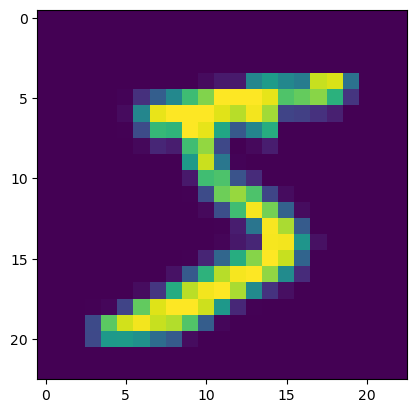

In [128]:
plt.imshow(data_trans[0])

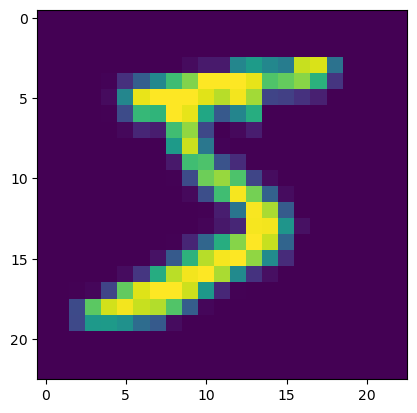

In [129]:
plt.imshow(mura.FFT_convolve(mura_data[0].numpy(),G,p))

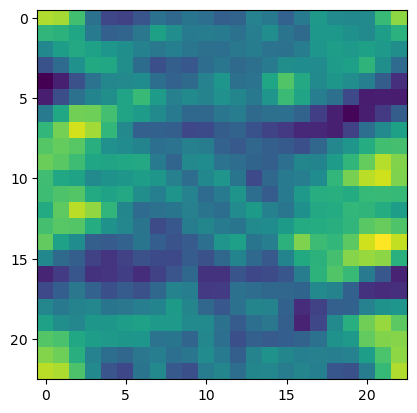

In [130]:
plt.imshow(mura_data[0])

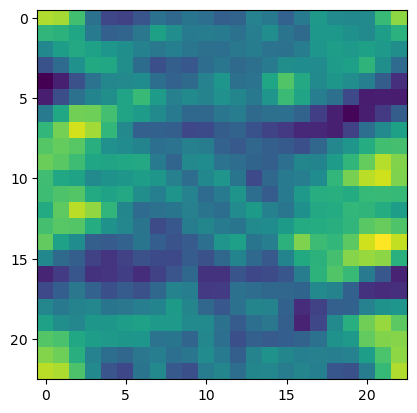

In [132]:
plt.imshow(mura.FFT_convolve(np.squeeze(data_trans[0].numpy()), A,p))

In [97]:
ex = torch.tensor(mura.normalize(mura.FFT_convolve(
                    np.squeeze(data_trans[0].numpy()), A,p)), dtype= torch.float)

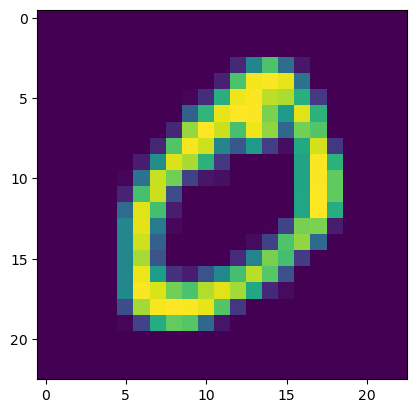

In [100]:
plt.imshow(data_trans[1])

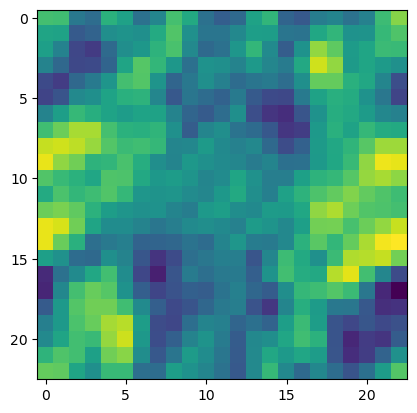

In [101]:
plt.imshow(ex)